<a href="https://colab.research.google.com/github/Jaimemorillo/ShouldIwatchThisMovie/blob/master/nice_movie_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [102]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [103]:
import pandas as pd
import tensorflow as tf
import time
import numpy as np
import json
import nltk

nltk.download("popular")
print(tf.__version__)

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

In [0]:
dataover = pd.read_csv("gdrive/My Drive/TFG/tmdb_spanish_overview.csv",sep='#',lineterminator='\n')
taste = pd.read_csv("gdrive/My Drive/TFG/tmdb_spanish_Jaime2.csv",sep=';', encoding='utf-8')
credits = pd.read_csv("gdrive/My Drive/TFG/tmdb_5000_credits.csv")

In [0]:
taste = taste[~taste['id'].str.contains('/')]
taste['id'] = taste['id'].astype(int)
credits['movie_id'] = credits['movie_id'].astype(int)

In [0]:
# Merge taste and credits

data = taste.merge(dataover[['id','overview']], left_on='id', right_on='id')
data = data.merge(credits[['movie_id','cast','crew']], left_on='id', right_on='movie_id')
data.drop(['movie_id'],axis=1, inplace= True)

In [107]:
data = data[~pd.isna(data.overview)]
len(data)

4406

In [108]:
data = data.dropna(subset=['like'])
data['like'] = data['like'].astype(int)
data.reset_index(inplace=True,drop=True)
len(data)

816

In [0]:
# Clean overviews ver que ocurre con deadpool y deadpool 2 

import string

stop_words = pd.read_csv("gdrive/My Drive/TFG/stopwords-es.txt",header=None)
stop_words = stop_words[0].tolist() + ['secuela']

def normalize(s):
    replacements = (
        ("á", "a"),
        ("é", "e"),
        ("í", "i"),
        ("ó", "o"),
        ("ú", "u"),
    )
    for a, b in replacements:
        s = s.replace(a, b).replace(a.upper(), b.upper())
    return s

def clean_overview(x):
    x = normalize(x.lower())
    x = x.translate(str.maketrans('','',string.punctuation))
    x = x.translate(str.maketrans('','','1234567890ªº'))
    return x

def delete_stop_words(x):
    words = x.split(' ')
    words = [word for word in words if word not in stop_words]
    x = str(' '.join(words))
    return x


In [0]:
# Steaming overview

from nltk import word_tokenize
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer("spanish", ignore_stopwords=True)

def stem_sentence(sentence):
    stemmed_text = [stemmer.stem(word) for word in word_tokenize(sentence)]
    return " ".join(stemmed_text)
  

In [0]:
data['overview']=data['overview'].apply(lambda x: clean_overview(str(x)))
#data['overview']=data['overview'].apply(lambda x: delete_stop_words(x))

In [112]:
data.head(15)

,id,title,like,vote_average,overview,cast,crew
0,11,La guerra de las galaxias. Episodio IV: Una nu...,1,8.1,la princesa leia lider del movimiento rebelde ...,"[{""cast_id"": 3, ""character"": ""Luke Skywalker"",...","[{""credit_id"": ""52fe420dc3a36847f8000437"", ""de..."
1,12,Buscando a Nemo,1,7.6,nemo un pececillo hijo unico muy querido y pro...,"[{""cast_id"": 8, ""character"": ""Marlin (voice)"",...","[{""credit_id"": ""52fe420ec3a36847f80006b1"", ""de..."
2,13,Forrest Gump,1,8.2,forrest gump es un chico con deficiencias ment...,"[{""cast_id"": 7, ""character"": ""Forrest Gump"", ""...","[{""credit_id"": ""52fe420ec3a36847f800076b"", ""de..."
3,22,Piratas del Caribe. La maldición de la Perla N...,1,7.5,el aventurero capitan jack sparrow recorre las...,"[{""cast_id"": 12, ""character"": ""Captain Jack Sp...","[{""credit_id"": ""52fe420fc3a36847f8000f11"", ""de..."
4,24,Kill Bill: Volumen 1,1,7.7,uma thurman es una asesina que el dia de su bo...,"[{""cast_id"": 3, ""character"": ""Beatrix 'The Bri...","[{""credit_id"": ""56a517709251410c080054d2"", ""de..."
5,35,Los Simpson: La película,1,6.9,homer debe salvar al mundo de una catastrofe q...,"[{""cast_id"": 2, ""character"": ""Homer / Itchy / ...","[{""credit_id"": ""52fe4211c3a36847f8001521"", ""de..."
6,58,Piratas del Caribe: El cofre del hombre muerto,1,7.0,will turner y elizabeth swann se van a casar p...,"[{""cast_id"": 37, ""character"": ""Captain Jack Sp...","[{""credit_id"": ""52fe4211c3a36847f8001873"", ""de..."
7,62,2001: Una odisea del espacio,1,7.9,la historia de la humanidad en diversos estadi...,"[{""cast_id"": 6, ""character"": ""Dr. Dave Bowman""...","[{""credit_id"": ""52fe4212c3a36847f8001a05"", ""de..."
8,65,8 millas,1,NaN,detroit la promesa de potencia industrial se ...,"[{""cast_id"": 3, ""character"": ""Jimmy B. \""Rabbi...","[{""credit_id"": ""52fe4212c3a36847f8001c6b"", ""de..."
9,70,Million Dollar Baby,1,7.7,frankie dunn despues de haber entrenado y repr...,"[{""cast_id"": 4, ""character"": ""Frankie Dunn"", ""...","[{""credit_id"": ""52fe4213c3a36847f800200b"", ""de..."


In [0]:
#data['overview']=data['overview'].apply(lambda x: stem_sentence(x))
#data['overview']=data['overview'].apply(lambda x: delete_stop_words(x))

In [114]:
data.head(15)

,id,title,like,vote_average,overview,cast,crew
0,11,La guerra de las galaxias. Episodio IV: Una nu...,1,8.1,la princesa leia lider del movimiento rebelde ...,"[{""cast_id"": 3, ""character"": ""Luke Skywalker"",...","[{""credit_id"": ""52fe420dc3a36847f8000437"", ""de..."
1,12,Buscando a Nemo,1,7.6,nemo un pececillo hijo unico muy querido y pro...,"[{""cast_id"": 8, ""character"": ""Marlin (voice)"",...","[{""credit_id"": ""52fe420ec3a36847f80006b1"", ""de..."
2,13,Forrest Gump,1,8.2,forrest gump es un chico con deficiencias ment...,"[{""cast_id"": 7, ""character"": ""Forrest Gump"", ""...","[{""credit_id"": ""52fe420ec3a36847f800076b"", ""de..."
3,22,Piratas del Caribe. La maldición de la Perla N...,1,7.5,el aventurero capitan jack sparrow recorre las...,"[{""cast_id"": 12, ""character"": ""Captain Jack Sp...","[{""credit_id"": ""52fe420fc3a36847f8000f11"", ""de..."
4,24,Kill Bill: Volumen 1,1,7.7,uma thurman es una asesina que el dia de su bo...,"[{""cast_id"": 3, ""character"": ""Beatrix 'The Bri...","[{""credit_id"": ""56a517709251410c080054d2"", ""de..."
5,35,Los Simpson: La película,1,6.9,homer debe salvar al mundo de una catastrofe q...,"[{""cast_id"": 2, ""character"": ""Homer / Itchy / ...","[{""credit_id"": ""52fe4211c3a36847f8001521"", ""de..."
6,58,Piratas del Caribe: El cofre del hombre muerto,1,7.0,will turner y elizabeth swann se van a casar p...,"[{""cast_id"": 37, ""character"": ""Captain Jack Sp...","[{""credit_id"": ""52fe4211c3a36847f8001873"", ""de..."
7,62,2001: Una odisea del espacio,1,7.9,la historia de la humanidad en diversos estadi...,"[{""cast_id"": 6, ""character"": ""Dr. Dave Bowman""...","[{""credit_id"": ""52fe4212c3a36847f8001a05"", ""de..."
8,65,8 millas,1,NaN,detroit la promesa de potencia industrial se ...,"[{""cast_id"": 3, ""character"": ""Jimmy B. \""Rabbi...","[{""credit_id"": ""52fe4212c3a36847f8001c6b"", ""de..."
9,70,Million Dollar Baby,1,7.7,frankie dunn despues de haber entrenado y repr...,"[{""cast_id"": 4, ""character"": ""Frankie Dunn"", ""...","[{""credit_id"": ""52fe4213c3a36847f800200b"", ""de..."


In [0]:
# Get staff and paste to overview

def get_actors(cast):
  
  try:
    
    json_cast = json.loads(cast)
  
  except:
    
    json_cast = cast
  
  if len(json_cast) > 2:
    up = 3
  else:
    up = len(json_cast)

  actors = ''
  
  for i in range(0,up):
    actor = json_cast[i]['name']
    actor = normalize(actor.replace(' ','_').lower())
  
    actors = actors + ' ' + actor
  
  return actors

def get_director(crew):
  
  try:
    
    json_crew = json.loads(crew)
  
  except:
    
    json_crew = crew
  
  directors = [member['name'] for member in json_crew if member['job'] == 'Director']
  directors = [normalize(director.replace(' ','_').lower()) for director in directors]
  directors = str(' '.join(directors))
  
  return directors

In [0]:
data['overview']=data.apply(lambda x: get_actors(x['cast']) + ' ' + x['overview'] , axis=1)
data['overview']=data.apply(lambda x: get_director(x['crew']) + x['overview'] , axis=1)

In [117]:
data['overview'][0]

'george_lucas mark_hamill harrison_ford carrie_fisher la princesa leia lider del movimiento rebelde que desea reinstaurar la republica en la galaxia en los tiempos ominosos del imperio es capturada por las malevolas fuerzas imperiales capitaneadas por el implacable darth vader el sirviente mas fiel del emperador el intrepido luke skywalker ayudado por han solo capitan de la nave espacial el halcon milenario y los androides rd y cpo seran los encargados de luchar contra el enemigo y rescatar a la princesa para volver a instaurar la justicia en el seno de la galaxia'

In [0]:
from sklearn.model_selection import train_test_split

overviews = data['overview'].values
y = data['like'].values

overviews_train, overviews_test, y_train, y_test = train_test_split(overviews, y, test_size=0.2, stratify=y)

In [0]:
columns_train = {'Overview': overviews_train, 'Like': y_train}
train = pd.DataFrame(data=columns_train)
train.to_csv('train' + '.csv', sep=';', encoding='utf-8', index=False)

columns_test = {'Comment': overviews_test, 'Like': y_test}
test = pd.DataFrame(data=columns_test)
test.to_csv('test' + '.csv', sep=';', encoding='utf-8', index=False)

In [0]:
# Embedding
num_words = 9000
maxlen = 90
embedding_size = 300

# Convolution
kernel_size = 5
filters = 300
pool_size = 2

hidden_dims = 300


# LSTM
lstm_output_size = 70

# Training
lr=0.0005
#lr=0.0001

In [121]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words) 
tokenizer.fit_on_texts(overviews_train)

X_train = tokenizer.texts_to_sequences(overviews_train) 
X_test = tokenizer.texts_to_sequences(overviews_test)

vocab_size = len(tokenizer.word_index) + 1 # Adding 1 because of reserved 0 index

print(overviews_train[2]) 
print(X_train[2]) 
print(vocab_size)

hironobu_sakaguchi motonori_sakakibara donald_sutherland ming-na_wen alec_baldwin corre el año  y la tierra ha sido devastada por una invasión alienígena en los ojos de una joven se refleja tristeza y desolación mientras mira fijamente a la desértica tierra a su alrededor y la luz del sol demasiado brillante le dificulta la visión está sola entre nubes de polvo en un amenazador mundo de extraterrestres y sus ojos revelan un conflicto interno times square se desmorona en la oscuridad quemado casi hasta desaparecer pero en alguna parte grandes ejércitos retienen al ejército extraterrestre mientras la muerte acecha entre las sombras ella busca el milagro creyendo en que los valores humanos como el valor la dedicación y el amor podrán finalmente salvar al planeta tierra
[5200, 5201, 5202, 5203, 1416, 3290, 2332, 2333, 2334, 5204, 5205, 2335, 4, 5206, 6, 2, 56, 24, 117, 2336, 16, 10, 5207, 5208, 7, 11, 985, 1, 10, 42, 12, 5209, 1769, 6, 5210, 40, 5211, 3291, 5, 2, 5212, 56, 5, 9,

In [122]:
# Crear pre-trained emmbeding

def create_embedding_matrix(filepath, word_index, embedding_size):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_size))

    with open(filepath, encoding='utf-8') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_size]

    return embedding_matrix
  
embedding_matrix = create_embedding_matrix(
    'gdrive/My Drive/TFG/SBW-vectors-300-min5.txt',
    tokenizer.word_index, embedding_size)

print(embedding_matrix[1])

nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

[-2.96480004e-02  1.13359997e-02  1.99490003e-02 -8.88319984e-02
 -2.52250005e-02  5.68439998e-02  2.54730005e-02  1.40680000e-02
  1.63693994e-01 -6.71539977e-02  1.47380000e-02  2.71339994e-02
  6.64430037e-02 -4.48459983e-02 -4.49870005e-02 -4.08979990e-02
  3.03109996e-02  3.41960005e-02 -4.92400005e-02  8.53700005e-03
 -6.80909976e-02 -8.79380032e-02  3.53000015e-02  1.49385005e-01
 -1.23500004e-02  1.26130003e-02  2.93499995e-02  6.95960000e-02
  3.91109996e-02  5.76520003e-02  6.99540004e-02 -6.62169978e-02
 -4.17839997e-02  2.86229998e-02  2.67719999e-02 -6.63919970e-02
  2.95299990e-03 -1.21879997e-02 -3.03630009e-02  4.02220003e-02
  3.48579995e-02  2.74689998e-02 -2.90339999e-02 -4.87480015e-02
 -3.85820009e-02 -5.15529998e-02 -3.35009992e-02 -1.90079994e-02
  3.04299989e-03  1.10711999e-01 -2.50959992e-02  1.11082003e-01
  3.52439992e-02  1.14207000e-01  1.01950001e-02  5.15110008e-02
 -4.06490006e-02 -1.13944001e-01  4.48729992e-02  5.20110019e-02
  6.73599988e-02  4.90540

0.7873632010943913

In [123]:
from collections import OrderedDict

dictWords = dict(tokenizer.word_counts)

print(len(dictWords) + 1)

for k,v in list(dictWords.items()):
    if v < 2 :
        del dictWords[k]
        
print(len(dictWords) + 1) 
# Para establecer el tamaño de maxlen

len(max(X_train, key=len))

11696
5183


184

In [124]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

X_train[1]

array([  76, 5194,    2,  253,   71,    6,   55,    3, 1181,   10,   76,
        673,   36, 2328,    3, 5195,   28, 5196,  750,  189, 1765,   46,
          2, 5197,    1,  442, 3286,  983,    6,  215,  295, 1414, 1182,
          7,  116,  984,   40,   12, 1766,   10,  100, 2329,    3,  239,
          5,  138,    2,  240,   15,  345,  983,   12,  372, 5198,    5,
        873, 3287, 5199,   77,    4, 1415,    2, 1767,    4, 1768,    6,
          4,  124,  254,    1, 3285,    6,  156,  274,    5,    2,  149,
       2330,   16, 2331, 3288,    7,   34,  874,   10, 3289,    7,    6,
        296,    7], dtype=int32)

In [0]:
#from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

#Optimizer

from tensorflow.keras import optimizers

adam = optimizers.Adam(lr)


es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=30,
                   verbose=0, mode='auto')

In [127]:
from sklearn.utils import class_weight


class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

class_weights

array([0.96735905, 1.03492063])

In [51]:
# Model 1

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D

model = Sequential()

model.add(Embedding(vocab_size,embedding_size, input_length=maxlen))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(500, activation='elu', kernel_initializer='he_uniform'))
model.add(Dropout(0.5))
model.add(Dense(500, activation='elu', kernel_initializer='he_uniform'))
model.add(Dropout(0.5))
model.add(Dense(500, activation='elu', kernel_initializer='he_uniform'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid', kernel_initializer='he_uniform'))
model.compile(optimizer=adam,
              loss='binary_crossentropy',
              metrics=['acc'])

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 90, 300)           2496000   
_________________________________________________________________
global_max_pooling1d_14 (Glo (None, 300)               0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 500)               150500    
_________________________________________________________________
dropout_13 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_14 (Dropout)         (None, 500)               0         
__________

In [28]:
# Model 2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding, BatchNormalization
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D,GlobalAveragePooling1D

model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(vocab_size,
                    embedding_size,
                    input_length=maxlen))


# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 strides=1, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('elu'))

# we use max pooling:

model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model.add(Dense(150, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Dropout(0.5))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1))
model.add(BatchNormalization())
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 90, 300)           2658300   
_________________________________________________________________
conv1d (Conv1D)              (None, 86, 300)           450300    
_________________________________________________________________
batch_normalization_v1 (Batc (None, 86, 300)           1200      
_________________________________________________________________
activation (Activation)      (None, 86, 300)           0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 300)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 150)               45150     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 150)               600       
__________

In [0]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Convolution1D, MaxPooling1D, Input
from tensorflow.keras.layers import Embedding,CuDNNLSTM, SpatialDropout1D, Reshape, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, GlobalAveragePooling1D, Concatenate
from tensorflow.keras.optimizers import Adam, Adagrad


def my_conv1d(kernel_size, layer, filters=10, strides=1):
  
  c1d = Conv1D(filters = filters, kernel_size = kernel_size, padding='same', strides=strides, kernel_initializer='he_uniform')(layer)
  c1d = BatchNormalization()(c1d)
  c1d = Activation('elu')(c1d)
  
  return c1d

def my_dense(neurons, ant, act='sigmoid', ini='glorot_uniform'):
  
  dense = Dense(neurons, kernel_initializer=ini)(ant)
  dense = BatchNormalization()(dense)
  dense = Activation(act)(dense)
  
  return dense

In [139]:
# Model 3

words = Input(shape=(maxlen,))
em =  Embedding(input_dim = vocab_size, output_dim = embedding_size, weights=[embedding_matrix], trainable=True)(words)
#em = Dropout(0.3)(em) 
c1 = my_conv1d(2,em, filters=300)
c2 = my_conv1d(3,em, filters=300)
c3 = my_conv1d(5,em, filters=300)

g1 = GlobalMaxPooling1D()(c1)
g2 = GlobalMaxPooling1D()(c2)
g3 = GlobalMaxPooling1D()(c3)

con = Concatenate(axis=1)([g1,g2,g3])

dense = Dropout(0.5)(con) 
pred = my_dense(1,dense)
model = Model(inputs=words, outputs=pred)

model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])
  
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 90)           0                                            
__________________________________________________________________________________________________
embedding_19 (Embedding)        (None, 90, 300)      3508800     input_17[0][0]                   
__________________________________________________________________________________________________
conv1d_49 (Conv1D)              (None, 90, 300)      180300      embedding_19[0][0]               
__________________________________________________________________________________________________
conv1d_50 (Conv1D)              (None, 90, 300)      270300      embedding_19[0][0]               
__________________________________________________________________________________________________
conv1d_51 

In [143]:
# Model RNN

from tensorflow.keras.layers import Bidirectional, LSTM, Flatten

words = Input(shape=(maxlen,))
em =  Embedding(input_dim = vocab_size, output_dim = embedding_size, weights=[embedding_matrix], trainable=True)(words)
#em = Dropout(0.3)(em) 

lstm_1 = Bidirectional(LSTM(64, name='blstm_1',
activation='tanh',
recurrent_activation='hard_sigmoid',
recurrent_dropout=0.0,
dropout=0.5, 
kernel_initializer='glorot_uniform',
return_sequences=True),
merge_mode='concat')(em)

lstm_1 = BatchNormalization()(lstm_1)

#Flatten
g1 = Flatten()(lstm_1)

drop3 = Dropout(0.5)(g1)

pred = my_dense(1,drop3)
model = Model(inputs=words, outputs=pred)

model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])
  
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 90)                0         
_________________________________________________________________
embedding_22 (Embedding)     (None, 90, 300)           3508800   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 90, 128)           186880    
_________________________________________________________________
batch_normalization_v1_75 (B (None, 90, 128)           512       
_________________________________________________________________
flatten_1 (Flatten)          (None, 11520)             0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 11520)             0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 11521     
__________

In [144]:
history = model.fit(X_train, y_train,
                    epochs=300,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=64, class_weight = class_weights, callbacks=[es])

Train on 652 samples, validate on 164 samples
Epoch 1/300
652/652 [==============================] - 8s 13ms/sample - loss: 0.7262 - acc: 0.5690 - val_loss: 0.7047 - val_acc: 0.5305
Epoch 2/300
652/652 [==============================] - 5s 7ms/sample - loss: 0.6280 - acc: 0.6626 - val_loss: 0.6972 - val_acc: 0.4878
Epoch 3/300
652/652 [==============================] - 5s 8ms/sample - loss: 0.5242 - acc: 0.7653 - val_loss: 0.6935 - val_acc: 0.4817
Epoch 4/300
652/652 [==============================] - 5s 7ms/sample - loss: 0.4206 - acc: 0.8850 - val_loss: 0.6923 - val_acc: 0.4817
Epoch 5/300
652/652 [==============================] - 5s 8ms/sample - loss: 0.3720 - acc: 0.9617 - val_loss: 0.6919 - val_acc: 0.4817
Epoch 6/300
652/652 [==============================] - 5s 7ms/sample - loss: 0.3609 - acc: 0.9709 - val_loss: 0.6905 - val_acc: 0.5305
Epoch 7/300
652/652 [==============================] - 5s 7ms/sample - loss: 0.3428 - acc: 0.9877 - val_loss: 0.6901 - val_acc: 0.5305
Epoch 8/

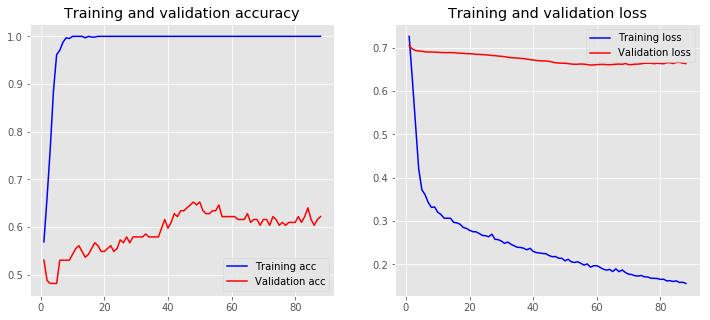

In [145]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
plot_history(history)

In [0]:
threshold = 0.5
y_score = model.predict(X_test)
#y_pred= model.predict_classes(X_neutral)
#y_test = y_netural

y_pred = y_score.copy()
y_pred[y_pred >=threshold] = 1
y_pred[y_pred <threshold] = 0

In [147]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

print("Confusion Matrix: \n" + str(confusion_matrix(y_test, y_pred)))
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred)))
print("Kappa: {:.4f}".format(cohen_kappa_score(y_test, y_pred)))
print("Precision: {:.4f}".format(precision_score(y_test, y_pred,pos_label=1)))
print("Recall: {:.4f}".format(recall_score(y_test, y_pred,pos_label=1)))
print("F1: {:.4f}".format(f1_score(y_test, y_pred,pos_label=1)))
print("Auc: {:.4f}".format(roc_auc_score(y_test, y_pred)))

Confusion Matrix: 
[[61 24]
 [38 41]]
Accuracy: 0.6220
Kappa: 0.2381
Precision: 0.6308
Recall: 0.5190
F1: 0.5694
Auc: 0.6183


In [0]:
model.save('nice_movie' + '_model2.h5')  

In [0]:
!pip install tmdbsimple

import tmdbsimple as tmdb

tmdb.API_KEY = '38dd5c6c01713ef99903275d51e2fd68'

In [0]:
def get_likeness(film):
  
  search = tmdb.Search()
  response = search.movie(query=film,language='es-ES')
  
  print(response)
  

  if len(response['results']) >= 1:
    over = response['results'][0]['overview']
    score = response['results'][0]['vote_average']
    
    id_movie = response['results'][0]['id']
    
    movie = tmdb.Movies(id_movie)
    
    actors = get_actors(movie.credits()['cast'])
    director = get_director(movie.credits()['crew'])
    
    over = clean_overview(str(over))
    over = delete_stop_words(over)

    over = actors + ' ' + over
    over = director + over
    
    print(over)
    
    X_over = tokenizer.texts_to_sequences(np.array([over]))
    X_over = pad_sequences(X_over, padding='post', maxlen=maxlen)

    probability = model.predict(X_over)
    print(probability)
    probability = probability[0][0] * 0.75 + (score/10)*0.25
    
    if (probability >= 0.5):
        pred = 1
        print(probability)
        if (probability < 0.5):
          probability = 0.5
        
    else:
        pred = 0
    
    return (str(pred) , str(probability), score/10)
  
  else:
    
    return 'No existe la peli'
  

In [0]:
movie = tmdb.Movies(64)
    
get_director(movie.credits()['crew'])

'pedro_almodovar'

In [0]:
get_likeness("la boda de mi mejor amiga")

{'page': 1, 'total_results': 1, 'total_pages': 1, 'results': [{'vote_count': 2682, 'id': 55721, 'video': False, 'vote_average': 6.5, 'title': 'La boda de mi mejor amiga', 'popularity': 13.59, 'poster_path': '/f5qGgjJYoG81SYAKF0VamjGrwd2.jpg', 'original_language': 'en', 'original_title': 'Bridesmaids', 'genre_ids': [35, 10749], 'backdrop_path': '/yMqCfrfz3QXGiurmXXP3pJIwKOR.jpg', 'adult': False, 'overview': 'Annie (Kristen Wiig) es una treintañera soltera del Medio Oeste, con una vida sentimental más bien precaria, a la que Lilliam, su mejor amiga (Maya Rudolph), le pide que sea su dama de honor. Sin embargo, aunque nunca ha ejercido esa función, la pobre se esfuerza por dárselas de snob en la fiesta anterior a la boda. Mientras tanto, otra amiga de Lillian (Rose Byrne) hará todo lo posible por arrebatarle el papel a la inexperta Annie', 'release_date': '2011-05-13'}]}
paul_feig kristen_wiig maya_rudolph rose_byrne annie kristen wiig treintañera soltera oeste vida sentimental precaria l

('0', '0.16622149306349457', 0.65)

In [0]:
word_embds = model.layers[1].get_weights()[0]
word_list = []
for word, i in tokenizer.word_index.items():
    word_list.append(word)

In [0]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(word_embds)
number_of_words = 1000
trace = go.Scatter(
    x = X_embedded[0:number_of_words,0], 
    y = X_embedded[0:number_of_words, 1],
    mode = 'markers',
    text= word_list[0:number_of_words]
)
layout = dict(title= 't-SNE 1 vs t-SNE 2 for sirst 1000 words ',
              yaxis = dict(title='t-SNE 2'),
              xaxis = dict(title='t-SNE 1'),
              hovermode= 'closest')
fig = dict(data = [trace], layout= layout)
py.iplot(fig)

In [0]:
import xgboost as xgb

#model = xgb.XGBClassifier(max_depth=10,n_estimators=150,silent=False,objective='binary:logistic')
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [0]:
y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)

In [0]:
!pip install finetune

In [0]:
from finetune import Classifier

model = Classifier()               # Load base model
model.fit(X_train, y_train)          # Finetune base model on custom data
y_pred = model.predict(X_test)